# Setup

In [ ]:
from pathlib import Path
import glob
import os
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

data_folder = 'AdvancedTimeSeriesCourse-Engineering-Data/Data'
if not os.path.exists(data_folder):
  !git clone https://github.com/ChristopherKunze-Git/AdvancedTimeSeriesCourse-Engineering-Data

dfs = {}
for filename in Path(f'{data_folder}').glob('*.csv'):
    print(filename.stem)
    df = pd.read_csv(filename)
    df['time'] = pd.to_datetime(df['time'])
    if 'old_time' in df.columns:
        df['old_time'] = pd.to_datetime(df['old_time'])
    dfs[filename.stem] = df

test_multi_no_gaps
train_multi
test_p27_no_gaps
train_multi_no_gaps
train_p27
test_multi
test_p27
train_p27_no_gaps


In [ ]:
import plotly.graph_objects as go

def plot_results(y, predictions, use_mean=False, title="", layout=None):

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=y.index, y=y, line_color='royalblue',
        name='Ground Truth'
    ))
    fig.add_trace(go.Scatter(
        x=predictions.index, y=predictions['low'],
        fill=None,
        line_color='rgba(200, 0, 0, 0.25)',
        fillcolor='rgba(200, 0, 0, 0.25)',
        legendgroup='Prediction',
        legendgrouptitle_text="Prediction",
        name='Lower bound'
    ))
    fig.add_trace(go.Scatter(
        x=predictions.index, y=predictions['high'],
        fill='tonexty', # fill area between trace0 and trace1
        line_color='rgba(200, 0, 0, 0.25)',
        fillcolor='rgba(200, 0, 0, 0.25)',
        legendgroup='Prediction',
        name='Upper bound'
    ))
    central_tendency = 'mean' if use_mean else 'median'
    fig.add_trace(go.Scatter(
        x=predictions.index,
        y=predictions[central_tendency],
        line_color='darkred',
        line_dash='dot',
        legendgroup='Prediction',
        name=central_tendency.capitalize()
    ))

    fig.update_layout(
        title = title,
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label="1d",
                        step="day",
                        stepmode="backward"),
                    dict(count=7,
                        label="1w",
                        step="day",
                        stepmode="backward"),
                    dict(count=1,
                        label="1m",
                        step="month",
                        stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )
    if layout is not None:
        fig.update_layout(layout)

    fig.show()

# Chronos zeroshot

In [ ]:
!pip -q install chronos-forecasting

In [ ]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import BaseChronosPipeline

pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-small",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    device_map="cuda",  # use "cpu" for CPU inference
    torch_dtype=torch.bfloat16,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
one_hour = 12
one_day = 24 * one_hour
one_week = 7 * one_day

train_df = dfs['train_p27_no_gaps'].set_index('time')
window = one_hour
horizon = one_day

_df = train_df['glucose_imp'][-2*one_week:]
n_past = 2*one_day
X = _df[:n_past]
y =_df[n_past:]

mean_preds = []
quantile_preds = []
for t in range(len(y)-window+1):
    bg_hist = pd.concat([X, y[:t]]).values

    quantiles, mean = pipeline.predict_quantiles(
        context = torch.tensor(bg_hist),
        prediction_length = one_hour,
        quantile_levels=[0.1, 0.5, 0.9],
    )
    if t == 0:
        mean_preds.extend(mean.squeeze().tolist())
        quantile_preds.append(quantiles.squeeze().numpy())
    else:
        mean_preds.append(mean.squeeze().numpy()[-1])
        quantile_preds.append(quantiles.squeeze().numpy()[[-1]])

mean = np.array(mean_preds)
quantiles = np.vstack(quantile_preds)
preds = np.hstack([mean[:, None], quantiles])
preds_df = pd.DataFrame(preds, columns=['mean', 'low', 'median', 'high'], index=y.index)

plot_results(_df, preds_df)

In [ ]:
one_hour = 12
one_day = 24 * one_hour
one_week = 7 * one_day

train_df = dfs['train_p27_no_gaps'].set_index('time')
test_df = dfs['test_p27_no_gaps'].set_index('time')
window = one_hour
horizon = one_day

X = train_df['glucose_imp']
y = test_df['glucose_imp']

mean_preds = []
quantile_preds = []
for t in range(len(y)-window+1):
    bg_hist = pd.concat([X, y[:t]]).values

    quantiles, mean = pipeline.predict_quantiles(
        context = torch.tensor(bg_hist),
        prediction_length = one_hour,
        quantile_levels=[0.1, 0.5, 0.9],
    )
    if t == 0:
        mean_preds.extend(mean.squeeze().tolist())
        quantile_preds.append(quantiles.squeeze().numpy())
    else:
        mean_preds.append(mean.squeeze().numpy()[-1])
        quantile_preds.append(quantiles.squeeze().numpy()[[-1]])

mean = np.array(mean_preds)
quantiles = np.vstack(quantile_preds)
preds = np.hstack([mean[:, None], quantiles])
preds_df = pd.DataFrame(preds, columns=['mean', 'low', 'median', 'high'], index=y.index)

_df = pd.concat([X.iloc[-one_day:], y])
plot_results(_df, preds_df)

In [ ]:
_df = pd.concat([X.iloc[-one_day:], y])
plot_results(_df, preds_df)

In [ ]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
print('RMSE:', root_mean_squared_error(y[window-1:], preds_df['median'][window-1:]))
print('MAPE:', mean_absolute_percentage_error(y[window-1:], preds_df['median'][window-1:]))

RMSE: 25.042219484238096
MAPE: 0.15305903433550636


# AutoGluon

In [ ]:
!pip -q install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. 

In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

train_data = TimeSeriesDataFrame.from_data_frame(
    train_df,
    id_column="subj",
    timestamp_column="time"
)
test_data = TimeSeriesDataFrame.from_data_frame(
    test_df,
    id_column="subj",
    timestamp_column="time"
)

n_steps = one_hour

## fit the model / fine tune it on train data
predictor = TimeSeriesPredictor(prediction_length = n_steps)
predictor = predictor.fit(
        train_data=train_data,
        hyperparameters={
            "Chronos": [
                {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
                {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
            ]
        },
        time_limit=600,  # time limit in seconds
        enable_ensemble=False,
)

## evaluate on test data
predictions = []
context_data = train_data[-one_day:] # we don't have to feed all into it every time..
y = test_data['target']

model = 'ChronosZeroShot[bolt_small]' # None

for t in range(len(y)-n_steps):
    eval_data, _ = pd.concat([context_data, test_data[:t]])
    pred = predictor.predict(eval_data, model=model)
    predictions.append(pred.iloc[-1:])
predictions = pd.concat(predictions)

predictor.plot(
    data=context_data,
    predictions=predictions,
    max_history_length=one_day,
);

In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

df = dfs['train_p27_no_gaps'].copy()
df['day_of_week'] = df['old_time'].dt.dayofweek
df['month'] = df['old_time'].dt.month
df.drop(columns=['old_time', 'glucose', 'heart_rate'], inplace=True)
df.rename(columns={'glucose_imp': 'target', 'heart_rate_imp': 'heart_rate'}, inplace=True)

data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="subj",
    timestamp_column="time"
)
data.head()

burned_calories  basal_insulin  bolus_insulin  \
item_id timestamp                                                            
P27     2020-06-26 22:15:00        22.655359          0.066            0.0   
        2020-06-26 22:20:00        21.161600          0.066            0.0   
        2020-06-26 22:25:00        25.642880          0.066            0.0   
        2020-06-26 22:30:00        12.572480          0.066            0.0   
        2020-06-26 22:35:00         6.721920          0.066            0.0   

                             hour_of_day  hour_sin  hour_cos  heart_rate  \
item_id timestamp                                                          
P27     2020-06-26 22:15:00           22      -0.5  0.866025   81.000000   
        2020-06-26 22:20:00           22      -0.5  0.866025   84.625000   
        2020-06-26 22:25:00           22      -0.5  0.866025   89.222222   
        2020-06-26 22:30:00           22      -0.5  0.866025   80.027778   
        2020-06-26 22:35:00           22      -0.5  0.866025   75.108108   

                             target  day_of_week  month  
item_id timestamp                                        
P27     2020-06-26 22:15:00   112.0            4      6  
        2020-06-26 22:20:00   105.0            4      6  
        2020-06-26 22:25:00    98.0            4      6  
        2020-06-26 22:30:00    91.0            4      6  
        2020-06-26 22:35:00    91.0            4      6

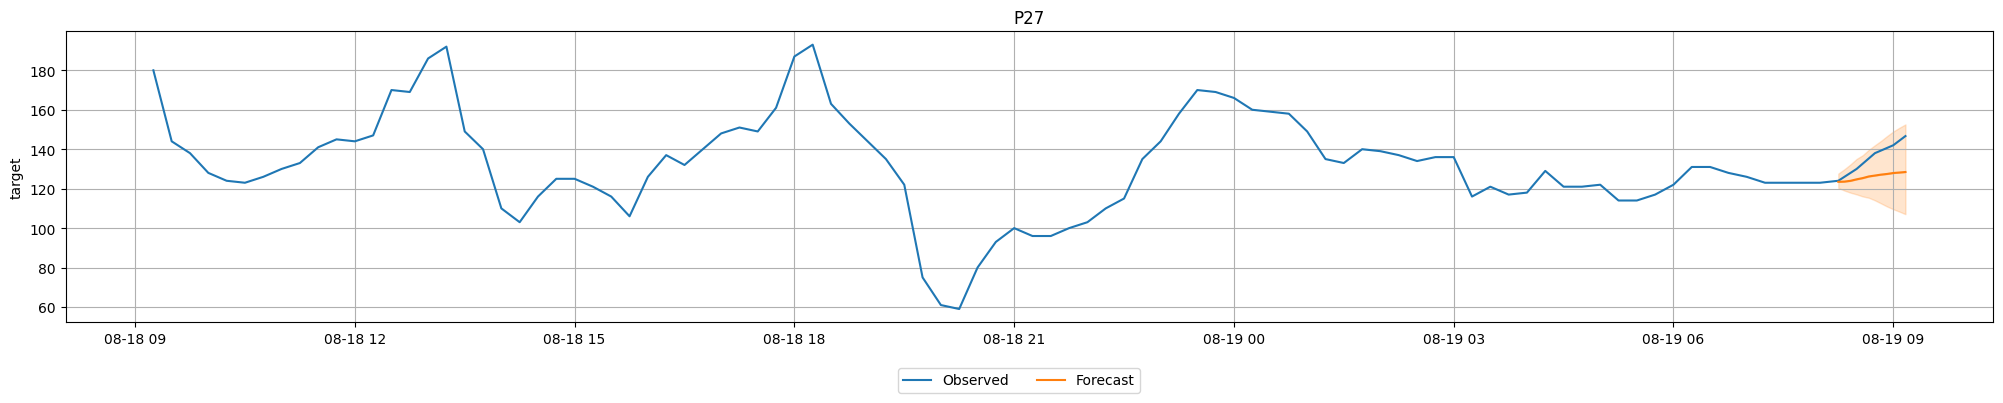

In [ ]:
prediction_length = one_hour
train_data, test_data = data.train_test_split(one_day)

predictor = TimeSeriesPredictor(
      prediction_length=prediction_length,
      quantile_levels=[0.1, 0.5, 0.9],
      verbosity=1,
  ).fit(train_data, presets="bolt_small")

predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:1],
    max_history_length=one_day,
);

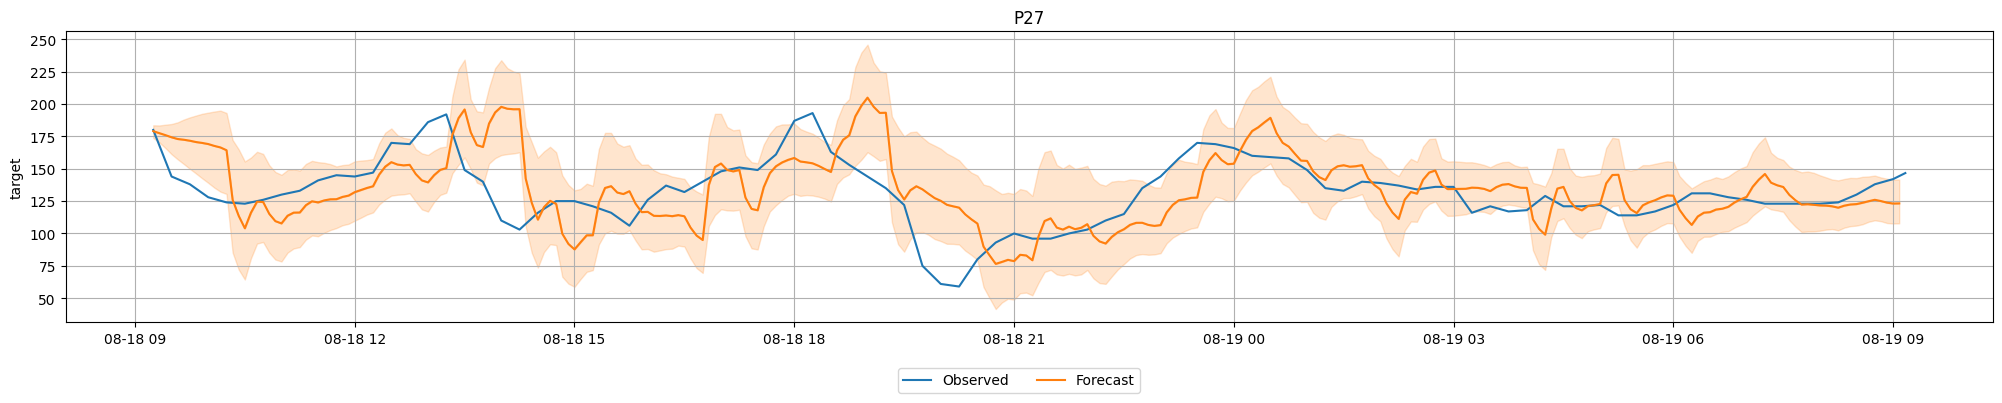

In [ ]:
predictions = []
context_data = data[-one_week:]
test_data = context_data[-one_day:]
y = test_data['target']

model = 'ChronosZeroShot[bolt_small]' # None

for t in range(one_day-one_hour):
    eval_data, _ = context_data.train_test_split(one_day-t)
    pred = predictor.predict(eval_data, model=model)

    if t == 0:
        predictions.append(pred)
    else:
        predictions.append(pred.iloc[-1:])

predictions = pd.concat(predictions)

predictor.plot(
    data=context_data,
    predictions=predictions,
    item_ids=context_data.item_ids[:1],
    max_history_length=one_day,
);

In [ ]:
print(f"RMSE: {root_mean_squared_error(y[prediction_length:], predictions['mean'][prediction_length-1:]):.2f}")
print(f"MAPE: {100*mean_absolute_percentage_error(y[prediction_length:], predictions['mean'][prediction_length-1:]):.2f}%")

RMSE: 26.95
MAPE: 16.99%


In [ ]:
print(f"RMSE: {root_mean_squared_error(y[prediction_length:], predictions['mean'][prediction_length-1:]):.2f}")
print(f"MAPE: {100*mean_absolute_percentage_error(y[prediction_length:], predictions['mean'][prediction_length-1:]):.2f}%")

RMSE: 27.58
MAPE: 17.49%


In [ ]:
train_data, test_data = data.train_test_split(one_day)

predictor = TimeSeriesPredictor(
        prediction_length=prediction_length)
predictor = predictor.fit(
        train_data=train_data,
        hyperparameters={
            "Chronos": [
                {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
                {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
            ]
        },
        time_limit=600,  # time limit in seconds
        enable_ensemble=False,
)

predictions = predictor.predict(train_data)
predictor.plot(
    data=train_data,
    predictions=predictions,
    item_ids=data.item_ids[:1],
    max_history_length=one_day,
);

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/content/AutogluonModels/ag-20250128_151453'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          1
Memory Avail:       7.69 GB / 12.67 GB (60.7%)
Disk Space Avail:   79.48 GB / 112.64 GB (70.6%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'model_path': 'bolt_small'}]},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 12,
 'quantile_levels': [0

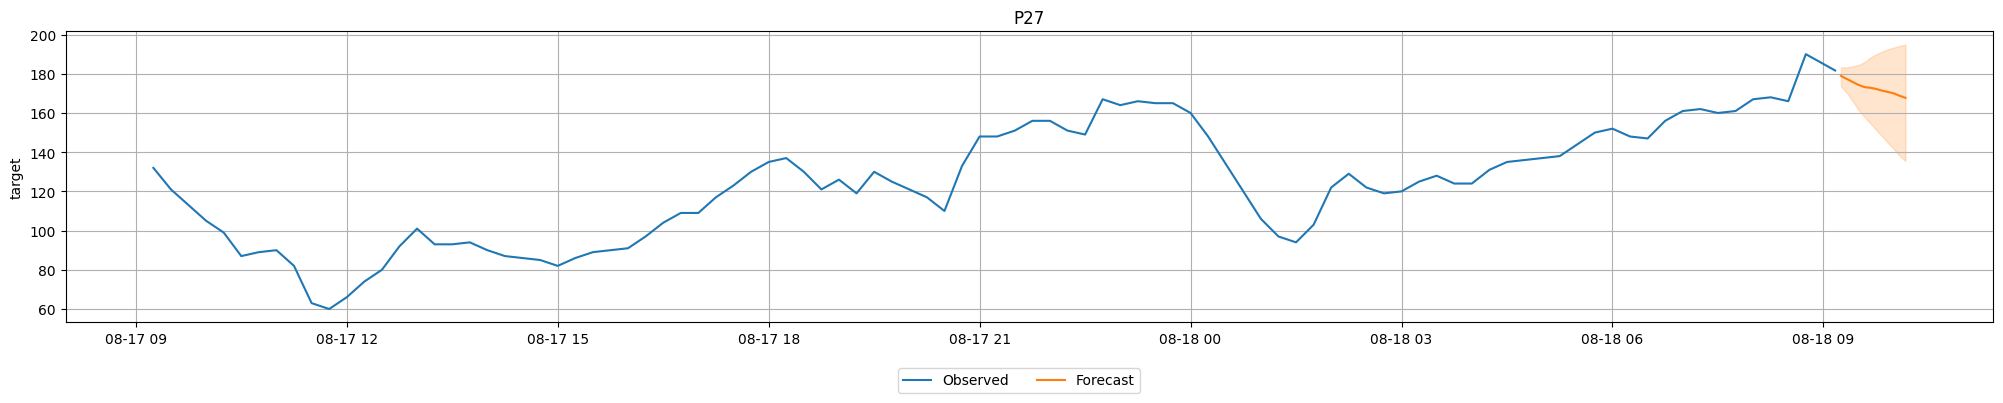

In [ ]:
predictions = predictor.predict(train_data, model='ChronosFineTuned[bolt_small]')
predictor.plot(
    data=train_data,
    predictions=predictions,
    item_ids=data.item_ids[:1],
    max_history_length=one_day,
);

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    known_covariates_names=["calories", "heart_rate", "steps", "basal_rate", "bolus_volume_delivered", "carb_input"],
).fit(
    train_data,
    hyperparameters={
        "Chronos": [
            # Zero-shot model WITHOUT covariates
            {
                "model_path": "bolt_small",
                "ag_args": {"name_suffix": "ZeroShot"},
            },
            # Chronos-Bolt (Small) combined with CatBoost on covariates
            {
                "model_path": "bolt_small",
                "covariate_regressor": "CAT",
                "target_scaler": "standard",
                "ag_args": {"name_suffix": "WithRegressor"},
            },
        ],
    },
    enable_ensemble=False,
    time_limit=60,
)



Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to '/content/AutogluonModels/ag-20250113_155636'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          1
Memory Avail:       9.19 GB / 12.67 GB (72.5%)
Disk Space Avail:   77.16 GB / 112.64 GB (68.5%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'WithRegressor'},
                                  'covariate_regressor': 'CAT',
                                  'model_path': 'bolt_small',
                                  'target_scaler': 'standard'}]},
 'known_covariates_names'